# Lesson 24: Monte Carlo simulation

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l24_monte_carlo.ipynb).*

In [2]:
# Our workhorse
import numpy as np

# Do it with compilation
import numba

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

In this lesson, we will put random number generation to use and do a **Monte Carlo simulation**.  The term Monte Carlo simulation is a broad term describing techniques in which a large number of random numbers are generated to (approximately) calculate properties of probability distributions.  In many cases the analytical form of these distributions is not known, so Monte Carlo methods are a great way to learn about then.

## Example Monte Carlo simulation: 1D random walk
Transcription, the process by which DNA is transcribed into RNA, is key process in the central dogma of molecular biology.  RNA polymerase (RNAP) is at the heart of this process.  This amazing machine glides along the DNA template, unzipping it internally, incorporating ribonucleotides at the front, and spitting RNA out the back.  Sometimes, though, the polymerase pauses and then backtracks, pushing the RNA transcipt back out the front, as shown in the figure below, taken from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009.

![Schematic of a pausing RNAP from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009](rnap_pause.png)

To escape these backtracks, a cleavage enzyme called TFIIS will cleave the bit on RNA hanging out of the front, and the RNAP can then go about its merry way.

Researchers have long debated how these backtracks are governed.  Single molecule experiments can provide some much needed insight.  The groups of Carlos Bustamante, Steve Block, and Stephan Grill, among others, have investigated the dynamics of RNAP in the absense of TFIIS.  They can measure many individual backtracks and get statistics about how long the backtracks last.

One hypothesis is that the backtracks simply consist of diffusive-like motion along the DNA stand.  That is to say, the polymerase can move forward or backward along the strand with equal probability once it is paused.  This is a one-dimensional **random walk**.  So, if we want to test this hypothesis, we would want to know what times we should expect for the time spent in the backtrack so that we could compare to experiment.

So, we seek the probability distribution of backtrack times, $P(t_{bt})$, where $t_{bt}$ is the time spent in the backtrack.  We could solve this analytically, which requires some sophisticated mathematics.  But, because we know how to draw random numbers, we can just compute this distribution directly using Monte Carlo simulation!

### How to compute the random walk
To compute a 1D random walk, we just need to compute a series of left and right steps.  This is just like flipping a coin over and over again.  So, if we want to compute an unbound 1D random walk, we just flip a coin over and over again and see where we end up.

In [3]:
def random_walk_1d(n_steps):
    """
    Take a random walk of n_steps and return excursion from the origin.
    """
    
    # Generate an array of our steps (+1 for right, -1 for left)
    steps = 2 * np.random.randint(0, 2, n_steps) - 1
    
    # Where we end up is the sum of these steps
    return steps.sum()

If we want the probability distribution of where we end up after $n_\mathrm{steps}$, we just do this over and over again.  We are then *sampling* out of the probability distribution, $P(x, n_\mathrm{steps})$, that describes displacement of the random walker as a function of the number of steps.  We'll generate 10,000 random walks, each of 10,000 steps, and compute the displacements for them.  We'll then plot a histogram to see how far the walkers tended to go.

In [4]:
# Number of steps to take for computing distribution
n_steps = 10000

# Number of random walks to take
n_samples = 10000

# Initial samples of displacements
x = np.empty(n_samples)

# Take all of the random walks
for i in range(n_samples):
    x[i] = random_walk_1d(n_steps)

We just generated 100 million random numbers to do that calculation!  Now, let's see what the distribution looks like.

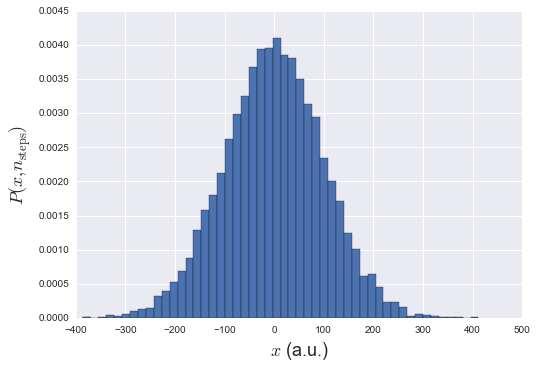

In [5]:
# Make histogram
_ = plt.hist(x, bins=50, normed=True)

# Label axes
plt.xlabel('$x$ (a.u.)')
plt.ylabel('$P(x, n_\mathrm{steps})$')

It looks approximately Gaussian.  We know theoretically that it is Gaussian with a mean of zero and standard deviation of $\sqrt{n_\mathrm{steps}}$.  Let's check.

In [6]:
print(' Mean displacement:', x.mean())
print('Standard deviation:', x.std())

 Mean displacement: -0.4628
Standard deviation: 100.244745579


Yup!  We're really close.

### First passage times
This is all fine and good, but we want to compute the probability distribution of how long it takes to get out of a backtrack!  So, we need to simulate a random walk during a backtrack.  So, we start at $x = 0$ at time $t = 0$.  We start taking steps, and as soon as $x$ becomes positive, we have existed the backtrack.  The total time for a backtrack is then $\tau n_\mathrm{steps}$, where $\tau$ is the time it takes to make a step.  Depken, et al., report that this is approximately a half second.

We first write a function to take a step.  At the top of the function is a **decorator**.  We will not cover decorators here, but this particular decorator is using the `numba` package to actually *compile* the following Python code.  Remember, compiled code is *much* faster than interpreted code, and the speed boost is needed in this case.

In [7]:
@numba.jit(nopython=True)
def backtrack_time():
    """
    Compute the number of steps it takes a 1d random walker starting
    at zero to get to +1.
    """

    # Initialize position and number of steps
    x = 0
    n_steps = 0
    
    # Walk until we get to positive 1
    while x < 1:
        x += 2 * np.random.randint(0, 2) - 1
        n_steps += 1
    
    return n_steps

Now that we have our function in place, we can perform our walks.  We will do 10,000 samples to compute the backtrack time.  Note that without using `numba`, this calculation would take several minutes.

In [14]:
# Stepping time
tau = 0.5 # seconds

# Specify number of samples
n_samples = 10000

# Array of backtrack times
t_bt = np.empty(n_samples)

# Generate the samples
for i in range(n_samples):
    t_bt[i] = backtrack_time()
    
# Convert to seconds
t_bt *= tau

Yay, `numba`!  That only took a few seconds.  Now, let's plot the histogram.

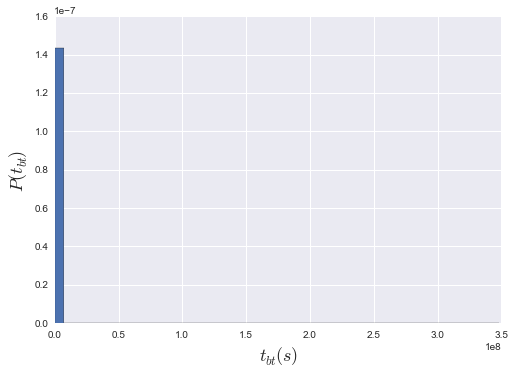

In [15]:
# Make histogram
_ = plt.hist(t_bt * tau, bins=50, normed = True)

# Label axes
plt.xlabel(r'$t_{bt} (s)$')
plt.ylabel('$P(t_{bt})$')

Yowza!  What is going on here?  We have some extremely long backtracks.  $10^7$ seconds is 115 days!  Obviously, a polymerase in such a backtrack would never escape.  The histogram is not the clear, so lets look at the cumulative histrogram.

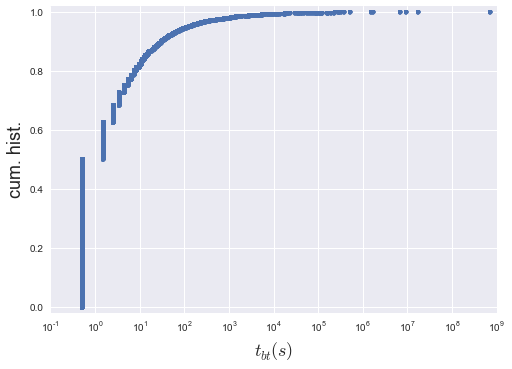

In [16]:
# Sort the samples
t_bt = np.sort(t_bt)

# Generate y-axis for CDF
y = np.arange(len(t_bt)) / len(t_bt)

# Plot CDF from random numbers
plt.semilogx(t_bt, y, '.', markersize=10)

# Clean up plot
plt.margins(y=0.02)
plt.xlabel(r'$t_{bt} (s)$')
plt.ylabel('cum. hist.')

This makes more sense.  We see that half of all backtracks end immediately, with the first step being rightward.  It is impossible to leave a backtrack in an even number of steps, so there are no two-step escapes.  Then, we get a lot of 3-step escapes, and so on.  But this goes more and more slowly.  Yes, 80% of backtracks only last 10 seconds, but there are still many extraordinarily long backtracks.  These are the fundamental predictions of our hypothesis.

### A power law?
A probability distribution that obeys a power law has the property

\begin{align}
P(x) \propto x^{-a}
\end{align}

in some part of the distribution, usually for large $x$.

The cumulative distribution is then

\begin{align}
\mathrm{cdf}(x) = \int_{-\infty}^x \mathrm{d}x'\,P(x') = 1 - \frac{c}{x^{a-1}},
\end{align}

where $c$ is some constant defined by the functional form of $P(x)$ for small $x$ and the normalization condition.  If $F$ is our cumulative histogram, we can check for power law behavior by plotting the complementarly cumulative probability distribution (CCDF), $1 - F$, versus $x$.  If a power law is in play, the plot will be linear on a log-log scale with a slope of $-a-1$.

By doing some mathematical heavy lifting, we know that, in the limit of large $t_{bt}$,

\begin{align}
P(t_{bt}) \propto t^{-3/2}.
\end{align}

We don't need to know that to see the linear trend on the log-log plot, but it is useful to plot along side it.

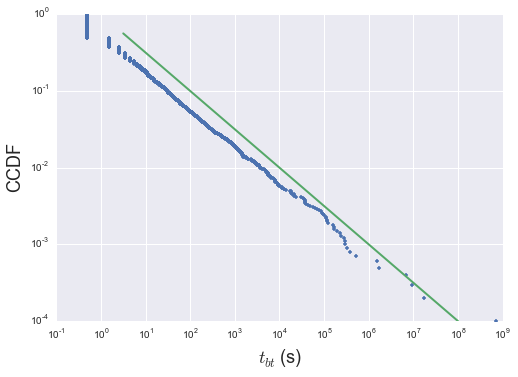

In [17]:
# Plot the CCDF
plt.loglog(t_bt, 1 - y, '.')

# Plot the asymptotic power law
t_smooth = np.logspace(0.5, 8, 100)
plt.loglog(t_smooth, 1 / np.sqrt(t_smooth))

# Label axes
plt.xlabel('$t_{bt}$ (s)')
plt.ylabel('CCDF')

Indeed, we see that the slope we got from Monte Carlo simulation matches what the theory predicts.  The theory to derive the probability distribution is involved.  See, e.g., [this](https://en.wikipedia.org/wiki/First-hitting-time_model).  However, we were able to predict that we would see a great many short backtracks, and then see some very very long backtracks because of the power law distribution of backtrack times.  We were able to do that just by doing a simple Monte Carlo simulation.  There are many problem where the theory is *really* hard, and deriving the distribution is currently impossible, or the probability distribution has such an ugly expression that we can't really work with it.  So, Monte Carlo methods are a powerful tool for generating predictions from simply-stated, but mathematically challenging, hypotheses.

Interestingly, many researchers thought (and maybe still do) there were two classes of backtracks: long and short.  There may be, but the hypothesis that the backtrack is a random walk process is commensurate with seeing both very long and very short backtracks.